In [1]:
%config IPCompleter.greedy=True

import pickle
import pandas as pd
import numpy as np
from collections import defaultdict

from combat.pycombat import pycombat

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

from scipy.spatial import distance
from scipy.cluster import hierarchy
import umap
import umap.plot
import networkx as nx
import sys
sys.path.insert(1, '../scripts_other/')
import cs_umap_plot

import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
import seaborn as sns


import os
import glob

import time
import datetime

print(datetime.datetime.now())

2023-05-10 07:55:37.764375


In [2]:
# INPUTS
path_features = '../data/d20220201/features/'
fn_patientmeta = '../metadata/Celine_FINAL_RADIOPOP_DATA_with LRE Death_220729.xlsx'

# OUTPUTS
path_umapPlots = '../figures/umapFigures_20210827/'
fn_metadatadf = '../data/d20220201/df_metadata_s20210827.p'
fn_featuresdf = '../data/d20220201/df_features_s20210827.p'
fn_featMetaArray = '../data/d20220201/arr_featAndMeta_s20210827.p'


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

try:
    os.mkdir(path_umapPlots)
except OSError:
    print ("Creation of the directory %s failed" % path_umapPlots)
else:
    print ("Successfully created the directory %s " % path_umapPlots)

Creation of the directory ../figures/umapFigures_20210827/ failed


In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

In [4]:
# massage features liver
df_features = pd.DataFrame()

listFiles = [x for x in os.listdir(path_features) if x.endswith('.p')]

for eaFile in listFiles:
    currPath = path_features + eaFile
    with open(currPath, "rb") as input_file:
         e = pickle.load(input_file)
    # turn into df
    tempdf = pd.DataFrame.from_dict(e)
    # keep rows starting with original (features)
    rows2keep = [s for s in tempdf.index if not s.startswith('diagnostics')]
    tempdf = tempdf[tempdf.index.isin(rows2keep)]
    # melt columns (liver,spleen) into feature space
    tempdf['feature']=tempdf.index + '_'
    df_melted = pd.melt(tempdf,id_vars=['feature'],value_vars=["liver","spleen"])
    df_melted['feature'] = df_melted['feature'] + df_melted['variable']
    df_melted = df_melted.drop(columns='variable')
    df_melted = df_melted.set_index('feature')
    # rename column to patient ID
    #currID = eaFile.split('features')[1].split('.')[0].zfill(4)
    currID = eaFile.split('.')[0].zfill(4)
    df_melted = df_melted.rename(columns={"value": currID})
    df_features = df_features.join(df_melted, how='outer')

df_features = df_features.astype(float)
df_features

,0192,0020,0028,0238,0435,0503,0055,0438,0224,0436,...,0023,1105,0424,0060,0137,0079,1065,0347,0354,0170
feature,,,,,,,,,,,,,,,,,,,,,
original_shape_Elongation_liver,0.756367,0.654448,0.667193,0.729500,0.704772,0.653324,0.769031,0.652144,0.695662,0.634796,...,0.736370,0.602208,0.740364,0.634271,0.731739,0.511178,0.609102,0.587750,0.623962,0.656860
original_shape_Flatness_liver,0.565690,0.433110,0.440543,0.444665,0.450656,0.425807,0.589348,0.429850,0.453306,0.500409,...,0.530826,0.511879,0.414716,0.474089,0.572395,0.310461,0.433495,0.363251,0.425256,0.471327
original_shape_LeastAxisLength_liver,104.799537,98.981281,103.781044,92.419653,100.053318,91.712940,131.302154,96.276737,102.716714,108.663498,...,93.051994,112.409159,83.578719,102.179786,106.220409,80.146324,93.015149,81.513908,97.814986,103.194791
original_shape_MajorAxisLength_liver,185.259513,228.536209,235.575261,207.841304,222.016949,215.386080,222.792114,223.977760,226.594804,217.149512,...,175.296748,219.601224,201.532335,215.528919,185.571719,258.152228,214.570480,224.401174,230.014359,218.945424
original_shape_Maximum2DDiameterColumn_liver,176.853046,261.535848,228.396585,218.686991,235.478237,236.222353,256.534598,220.737401,254.283307,242.260191,...,183.698122,223.396508,236.484672,216.171228,209.880919,256.222560,241.497412,198.758648,271.591605,208.213832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,0.017103,0.012354,0.050866,0.009087,0.005297,0.015579,0.014862,0.025905,0.009534,0.013695,...,0.013907,0.005041,0.011132,0.021916,0.009234,0.011376,0.020258,0.007566,0.004437,0.021851
wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,0.000617,0.000560,0.001140,0.000494,0.000322,0.000525,0.000639,0.001367,0.000541,0.000726,...,0.000440,0.000450,0.000364,0.001423,0.000460,0.000843,0.001099,0.000494,0.000320,0.001242
wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,0.126961,0.172409,0.080045,0.182755,0.215188,0.114625,0.142995,0.174630,0.190273,0.173560,...,0.118776,0.277216,0.137890,0.204042,0.165384,0.231352,0.185558,0.210315,0.234765,0.180802


In [5]:
with open(fn_featuresdf, 'wb') as handle:
    pickle.dump(df_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
metadata = pd.read_excel(fn_patientmeta, index_col=0, nrows=476, dtype=str)#, index_col=0, header=1, nrows=371, dtype=str)
#metadata

In [7]:
# load and clean metadata
metadata = pd.read_excel(fn_patientmeta, index_col=0, nrows=476, dtype=str)
#metadata = metadata.drop(columns=['owncloud', 'cohort training (0) testing (1)'])
# massage patient IDs to add leading zeros
metadata['patientID'] = metadata.index
metadata['expGrp'] = metadata['patientID'].apply(lambda x: 'cntl' if x>=1000 else 'risk')
metadata['patientID'] = metadata['patientID'].apply(lambda x: str(x).zfill(4))
metadata = metadata.set_index('patientID')
# clean each column
metadata = metadata.rename(columns={'age at CT': 'age'})
metadata = metadata.rename(columns={'HVPG-DATE ': 'HVPGdate'})

#temp_dict = {'0': 'male', '1': 'female', np.nan: 'unknown', ' ': 'unknown'}
temp_dict = {'0': 'male', '1': 'female', 'M': 'male'}
metadata['SEX'] = metadata['SEX'].apply(lambda x: temp_dict[x])
metadata = metadata.rename(columns={'SEX': 'sex'})

metadata = metadata.rename(columns={'BL_HVPG_corrected (ohne Kollat., inkor. Messungen)': 'HVPG'})
temp_dict = {np.nan: 0}
metadata['HVPG_toPredict'] = metadata['HVPG'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else (0 if float(x) < 10 else 1))

metadata = metadata.rename(columns={'CT date': 'CTdate'})
metadata = metadata.rename(columns={'CT machine group': 'CTgroup'})

metadata = metadata.rename(columns={'decomp at BL yes(1) no (0)': 'decomp'})
temp_dict = {1: 'yes', 0: 'no', np.nan: 'unknown'}
metadata['decomp'] = metadata['decomp'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

metadata = metadata.rename(columns={'LRE FU yes (1) no (0)': 'LRE'})
temp_dict = {1: 'yes', 0: 'no', np.nan: 'unknown'}
metadata['LRE'] = metadata['LRE'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

metadata = metadata.rename(columns={'which LRE ': 'LREwhich'})
metadata = metadata.rename(columns={'LRE date': 'LREdate'})
metadata = metadata.rename(columns={'LRE duration (months) from CT': 'LREduration'})
metadata = metadata.rename(columns={'TIPS date': 'TIPSdate'})
metadata = metadata.rename(columns={'LRD yes (1) no (0)': 'LRD'})
temp_dict = {1: 'yes', 0: 'no', np.nan: 'unknown'}
metadata['LRD'] = metadata['LRD'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

metadata = metadata.rename(columns={'reason death': 'deathReason'})
metadata = metadata.rename(columns={'death date': 'deathDate'})

metadata = metadata.rename(columns={'LRD duration (months) from CT': 'LRDduration'})
metadata = metadata.rename(columns={'LFU date ': 'deathDate'})
metadata = metadata.rename(columns={'overall survival yes (1) no (0)': 'overallSurvival'})
temp_dict = {1: 'yes', 0: 'no', np.nan: 'unknown'}
metadata['overallSurvival'] = metadata['overallSurvival'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

metadata = metadata.rename(columns={'overall survival duration (months) from CT': 'survivalDuration'})
metadata = metadata.rename(columns={'LTX date': 'LTXdate'})
metadata = metadata.rename(columns={'TFS-liver related duration (months) from CT': 'TFSduration'})
metadata = metadata.rename(columns={'LTX before': 'LTXbefore'})

metadata
# keyÍ
# OLTX: transplant
# TIPS: put shunt between two veins
# what is n in DEATH(Yes/No), OLTX (Yes/No)

,"Training = 0, Testing = 1",age,BL = CT-Datum,sex,DATEDIF BL CT,DATEDIF HVPG CT,HVPG-DATE STUDIE,New BL = CT date,CTgroup,ID.1,...,InclusionFVIIIPC_0;1,InclusionVWF_01,cACLDTimeDecompLiverRelDeathwithin360days,cACLDStatusDecompLiverRelDeathwithin360days,cACLDTimeDecompLiverRelDeath>360days,cACLDStatusDecompLiverRelDeath>360,TimeDecompLiverRelDeathwithCensoring360,StatusDecompLiverRelDeathwithCensoring360,expGrp,HVPG_toPredict
patientID,,,,,,,,,,,,,,,,,,,,,
0001,0,59,2017-11-30 00:00:00,female,0,-8,2017-11-22 00:00:00,2017-11-30 00:00:00,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,27.383300460223534,0,risk,1
0002,0,59,2018-10-25 00:00:00,female,NaN,6,2018-10-31 00:00:00,2018-10-25 00:00:00,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,12.590401051939512,0,risk,0
0004,0,60,2013-05-28 00:00:00,female,NaN,8,2013-06-05 00:00:00,2013-05-28 00:00:00,5,4,...,NaN,NaN,NaN,NaN,27.251808021038787,0,27.251808021038787,0,risk,0
0005,0,36,2018-12-13 00:00:00,female,0,43,2019-01-25 00:00:00,2018-12-13 00:00:00,2,5,...,NaN,NaN,NaN,NaN,15.384615384615383,0,15.384615384615383,0,risk,0
0006,0,44,2015-03-17 00:00:00,female,NaN,43,2015-04-29 00:00:00,2015-03-17 00:00:00,1,6,...,NaN,NaN,NaN,NaN,22.846811308349768,0,22.846811308349768,0,risk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0509,0,39,2015-09-30 00:00:00,male,NaN,42,2015-11-11 00:00:00,2015-09-30 00:00:00,1,509,...,NaN,NaN,NaN,NaN,NaN,NaN,54.99671268902038,0,risk,1
0510,0,49,2014-05-04 00:00:00,female,0,228,2014-12-18 00:00:00,2014-05-04 00:00:00,1,510,...,NaN,NaN,NaN,NaN,73.07692307692307,0,73.07692307692307,0,risk,1
0511,1,48,2013-08-05 00:00:00,male,0,169,2014-01-21 00:00:00,2013-08-05 00:00:00,1,511,...,NaN,NaN,NaN,NaN,NaN,NaN,22.32084155161078,1,risk,1


In [8]:
with open(fn_metadatadf, 'wb') as handle:
    pickle.dump(metadata, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
print('#risk: ')
print(len(metadata[metadata['expGrp']=='risk']))
print('#healthy: ')
print(len(metadata[metadata['expGrp']=='cntl']))

#risk: 
442
#healthy: 
0


In [ ]:
# translate metadata to dictionary for umap coloring
patientOrder = df_features.columns
patientOrder

# reduce metadata to those with feature data
currMeta = pd.DataFrame()
currMeta['patientID'] = patientOrder
currMeta = currMeta.merge(metadata, on='patientID')
#display(currMeta.head())
print(len(currMeta))

In [11]:
currFeatures = df_features.T.loc[currMeta['patientID']]
currFeatures

currFeatures_zscores = (currFeatures - currFeatures.mean()) / currFeatures.std()
currFeatures_zscores

feature,original_shape_Elongation_liver,original_shape_Flatness_liver,original_shape_LeastAxisLength_liver,original_shape_MajorAxisLength_liver,original_shape_Maximum2DDiameterColumn_liver,original_shape_Maximum2DDiameterRow_liver,original_shape_Maximum2DDiameterSlice_liver,original_shape_Maximum3DDiameter_liver,original_shape_MeshVolume_liver,original_shape_MinorAxisLength_liver,...,wavelet-LLL_gldm_GrayLevelNonUniformity_spleen,wavelet-LLL_gldm_GrayLevelVariance_spleen,wavelet-LLL_gldm_HighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen
0192,1.276071,1.838378,0.437521,-1.357841,-1.906287,0.792160,-0.957345,-1.528848,-0.229739,-0.191734,...,-0.115446,-0.462721,-0.445054,1.231148,0.340318,0.537728,-0.059403,-1.278140,-0.811425,-0.702420
0020,0.089857,-0.124301,0.050633,0.150214,0.734539,-0.269149,0.301576,0.233138,0.111433,0.271473,...,-1.063880,-0.154840,-0.099950,0.730312,0.513549,-0.007851,-0.234027,-0.416282,-0.393838,0.063501
0028,0.238199,-0.014263,0.369795,0.395503,-0.298906,-0.020739,0.687367,0.099234,0.164227,0.644810,...,0.493878,-0.594839,-1.225617,4.118530,0.270153,4.416392,1.559330,-2.167843,-1.347962,-0.014474
0238,0.963371,0.046750,-0.385686,-0.570937,-0.601699,-0.218343,-0.122622,-0.269028,-0.188073,0.372306,...,0.824462,-0.265428,0.020960,-0.182518,-0.072833,-0.383174,-0.439122,-0.220079,-0.084899,-0.600261
0435,0.675569,0.135449,0.121918,-0.076961,-0.078065,0.355517,-0.268379,-0.250824,-0.000186,0.610321,...,-0.328012,0.210854,1.318580,-0.333434,0.940411,-0.818534,-0.971141,0.394979,1.042756,-0.772460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0137,0.989429,1.937636,0.532002,-1.346962,-0.876316,-0.077944,-1.169531,-0.864234,-0.370614,-0.404384,...,4.421333,-0.229208,0.193653,0.130497,0.348290,-0.366234,-0.546492,-0.549494,-0.180901,-0.759200
0079,-1.577637,-1.939946,-1.201808,1.182239,0.568845,-0.622834,0.217633,0.105304,-0.812094,-0.592215,...,-0.547894,0.174765,-0.812250,-0.848509,-1.061101,-0.120186,0.641327,0.701508,-0.415151,1.096111
0347,-0.686426,-1.158471,-1.110869,0.006122,-1.223163,-0.118305,-0.550104,0.021958,-0.610770,-0.595643,...,-0.033303,0.056014,0.100292,-0.534294,-0.222680,-0.557881,-0.438968,0.302564,0.138590,-0.252183
0354,-0.264958,-0.240567,-0.026921,0.201723,1.048127,0.169455,-0.555786,0.617094,-0.297427,-0.025104,...,-0.251121,-0.011126,1.270663,-0.817040,0.319626,-0.917279,-0.979639,0.766222,1.381894,-0.796810


In [12]:
with open(fn_metadatadf, 'wb') as handle:
    pickle.dump(metadata, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
allFeatures = {'data': currFeatures.to_numpy(),
               'data_zscores': currFeatures_zscores.to_numpy(),
               'age': currMeta['age'].astype(float).to_numpy(),
               #'HVPGdate': currMeta['HVPGdate'].astype(float).to_numpy(),
               'sex': currMeta['sex'].to_numpy(),
               'HVPG': currMeta['HVPG'].astype(float).to_numpy(),
               'HVPG_toPredict': currMeta['HVPG_toPredict'].astype(float).to_numpy(),
               #'CTdate': currMeta['CTdate'].to_numpy(),
               'CTgroup': currMeta['CTgroup'].to_numpy(),
               'decomp': currMeta['decomp'].to_numpy(),
               'LRE': currMeta['LRE'].to_numpy(),
               'LREwhich': currMeta['LREwhich'].to_numpy(),
               #'LREdate': currMeta['LREdate'].to_numpy(),
               'LREduration': currMeta['LREduration'].astype(float).to_numpy(),
               #'TIPSdate': currMeta['TIPSdate'].to_numpy(),
               'LRD': currMeta['LRD'].to_numpy(),
               'deathReason': currMeta['deathReason'].to_numpy(),
               #'deathDate': currMeta['deathDate'].to_numpy(),
               'LRDduration': currMeta['LRDduration'].astype(float).to_numpy(),
               'overallSurvival': currMeta['overallSurvival'].to_numpy(),
               'survivalDuration': currMeta['survivalDuration'].astype(float).to_numpy(),
               #'LTXdate': currMeta['LTXdate'].to_numpy(),
               'TFSduration': currMeta['TFSduration'].astype(float).to_numpy(),
               #'LTXbefore': currMeta['LTXbefore'].to_numpy(),
               'expGrp': currMeta['expGrp'].to_numpy()}

In [14]:
with open(fn_featMetaArray, 'wb') as handle:
    pickle.dump(allFeatures, handle, protocol=pickle.HIGHEST_PROTOCOL)

Text(0.5, 1.0, 'CT group, raw')

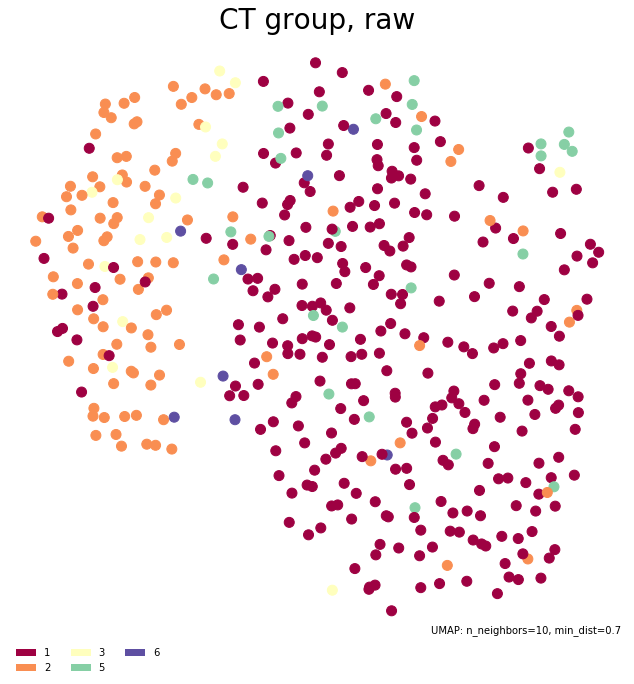

In [15]:
## play with umap parameters
# goal: somethign that separates mmHg
# goal: check if there is batch effect from CT 

fit = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding = fit.fit_transform(allFeatures['data_zscores'])
mapper = fit.fit(allFeatures['data_zscores'])

ax = cs_umap_plot.points(mapper, labels=allFeatures['CTgroup'], point_size=100, show_legend=True)
ax.axis('off')
plt.title('CT group, raw')

# grp1(left) seems to separate from grp2(right)

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


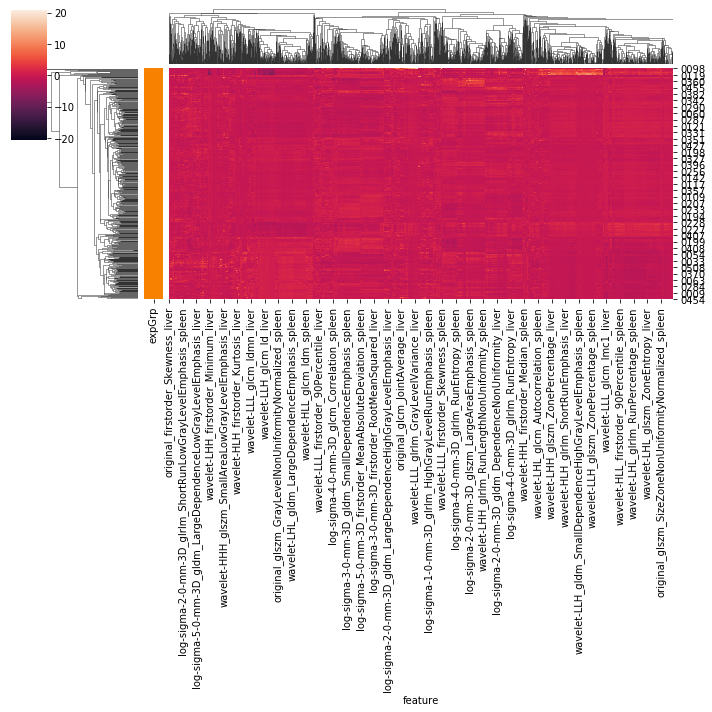

In [16]:
lut = dict(zip(currMeta['expGrp'].unique(), ['#F88100', '#DFDC00']))
row_colors = currMeta.set_index('patientID')['expGrp'].map(lut)

sns.clustermap(currFeatures_zscores.astype(float), 
               row_colors = row_colors)

In [17]:
# from combat.pycombat import pycombat
# data_corrected = pycombat(data,batch)
# data: The expression matrix as a dataframe - gene expression (rows) for each sample (columns).
# batch: List of batch indexes - list of batches contains as many elements as the number of columns in the expression matrix.
currFeatures_combat = pycombat(currFeatures.transpose(), allFeatures['CTgroup'])
currFeatures_combat_zscores = (currFeatures_combat - currFeatures_combat.mean()) / currFeatures_combat.std()

allFeatures['data_combat'] = currFeatures_combat.transpose().to_numpy()
allFeatures['data_combat_znorm'] = currFeatures_combat_zscores.transpose().to_numpy()

Found 5 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


Text(0.5, 1.0, 'CT group +combat')

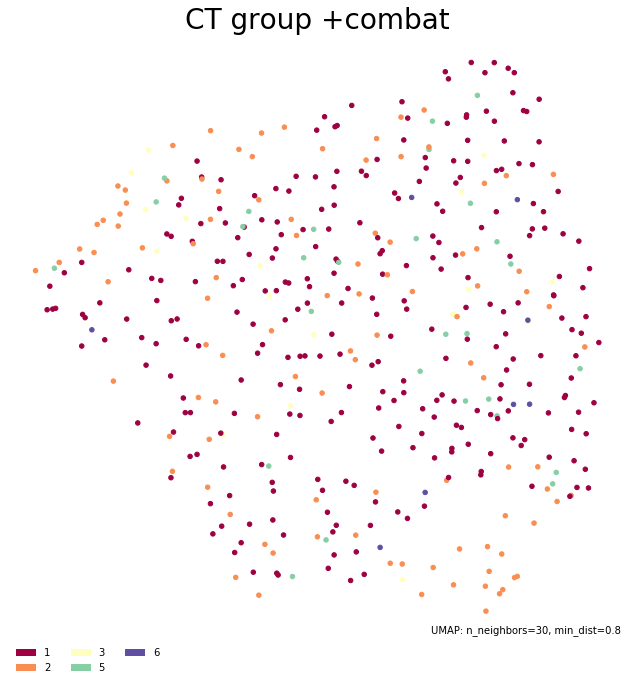

In [18]:
## play with umap parameters
# goal: somethign that separates mmHg
# goal: check if there is batch effect from CT 

fit = umap.UMAP(n_neighbors = 30,
                min_dist = 0.8)
embedding = fit.fit_transform(allFeatures['data_combat_znorm'])
mapper = fit.fit(allFeatures['data_combat_znorm'])

ax = cs_umap_plot.points(mapper, labels=allFeatures['CTgroup'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('CT group +combat')

# don't like results from combat...

In [19]:
# normalization within batches
ctgrp2pID = {ctgrp: list(currMeta[currMeta['CTgroup']==ctgrp]['patientID']) for ctgrp in currMeta['CTgroup'].unique()}

currFeatures_normctgrp = pd.DataFrame()

for eaGrp in ctgrp2pID:
    grpSize = len(ctgrp2pID[eaGrp])
    tempFeatures = currFeatures.loc[ctgrp2pID[eaGrp],:]
    tempFeatures = (tempFeatures - tempFeatures.mean()) / tempFeatures.std()
    tempFeatures = tempFeatures.replace(np.nan,0) # grp3, 'original_firstorder_Median_liver'
    currFeatures_normctgrp = currFeatures_normctgrp.append(tempFeatures)

# reorder
currFeatures_normctgrp = currFeatures_normctgrp.reindex(currFeatures_zscores.index)
# and store
allFeatures['data_normctgrp'] = currFeatures_normctgrp.to_numpy()

In [20]:
currFeatures_normctgrp.std()

feature
original_shape_Elongation_liver                                 0.995455
original_shape_Flatness_liver                                   0.995455
original_shape_LeastAxisLength_liver                            0.995455
original_shape_MajorAxisLength_liver                            0.995455
original_shape_Maximum2DDiameterColumn_liver                    0.995455
                                                                  ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen     0.995455
wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen                    0.995455
wavelet-LLL_gldm_SmallDependenceEmphasis_spleen                 0.995455
wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen    0.995455
wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen     0.995455
Length: 2436, dtype: float64

Text(0.5, 1.0, 'CT group, normByGrp')

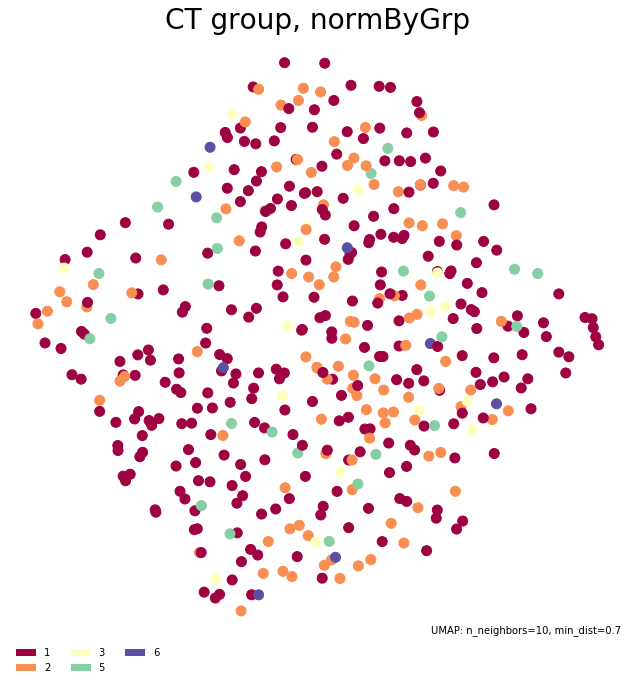

In [21]:
fit = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding = fit.fit_transform(allFeatures['data_normctgrp'])
mapper = fit.fit(allFeatures['data_normctgrp'])

ax = cs_umap_plot.points(mapper, labels=allFeatures['CTgroup'], point_size=100, show_legend=True)
ax.axis('off')
plt.title('CT group, normByGrp')

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


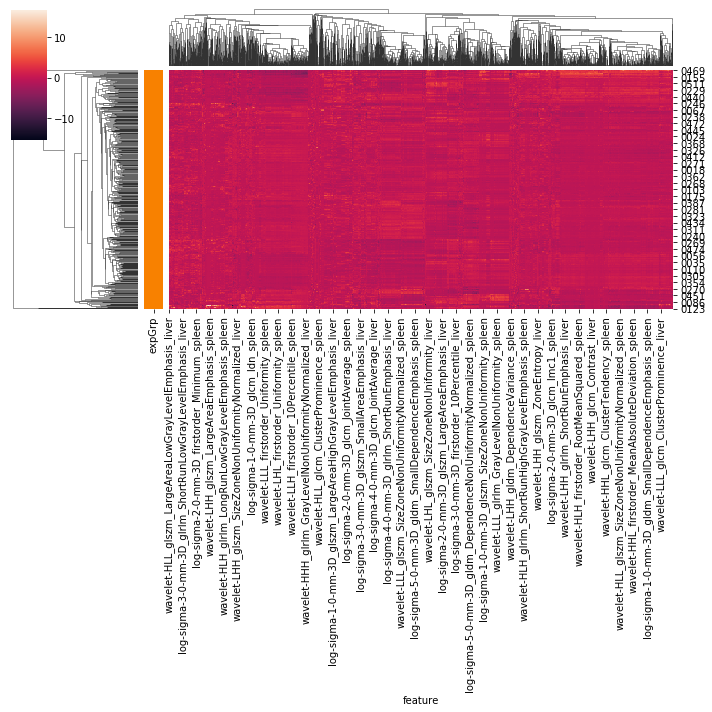

In [22]:
lut = dict(zip(currMeta['expGrp'].unique(), ['#F88100', '#DFDC00']))
row_colors = currMeta.set_index('patientID')['expGrp'].map(lut)

sns.clustermap(currFeatures_normctgrp.astype(float), 
               row_colors = row_colors)

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


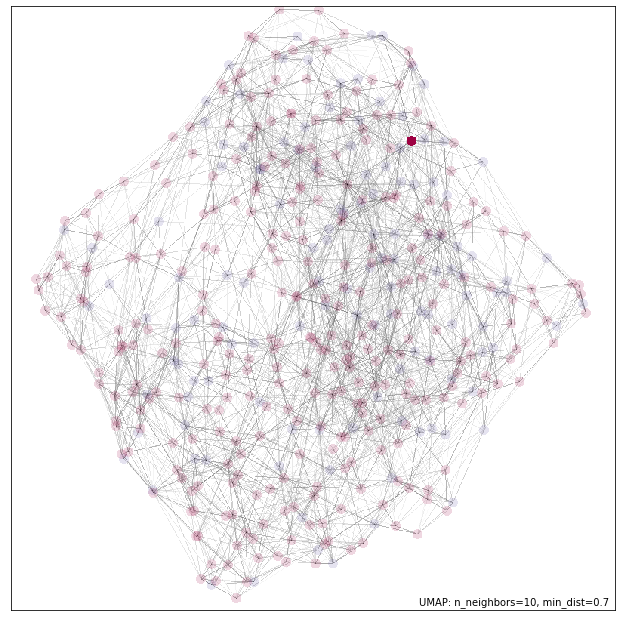

In [23]:
cs_umap_plot.connectivity(mapper, labels=allFeatures['sex'], show_points=True)

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


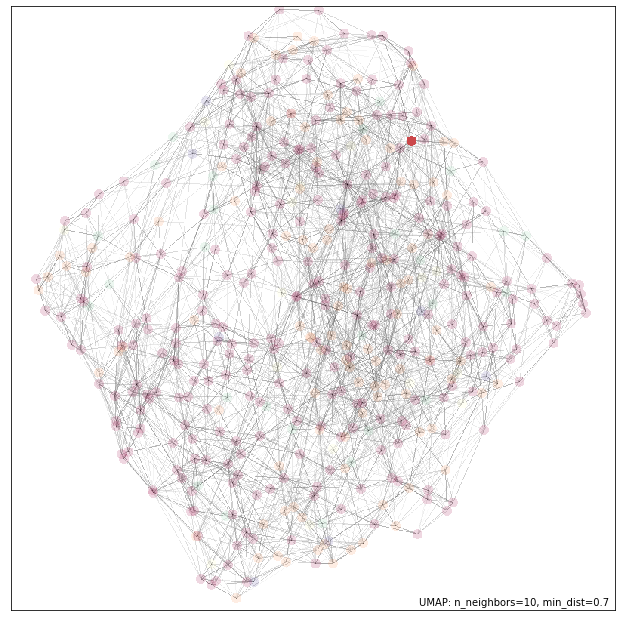

In [24]:
cs_umap_plot.connectivity(mapper, labels=allFeatures['CTgroup'], show_points=True)

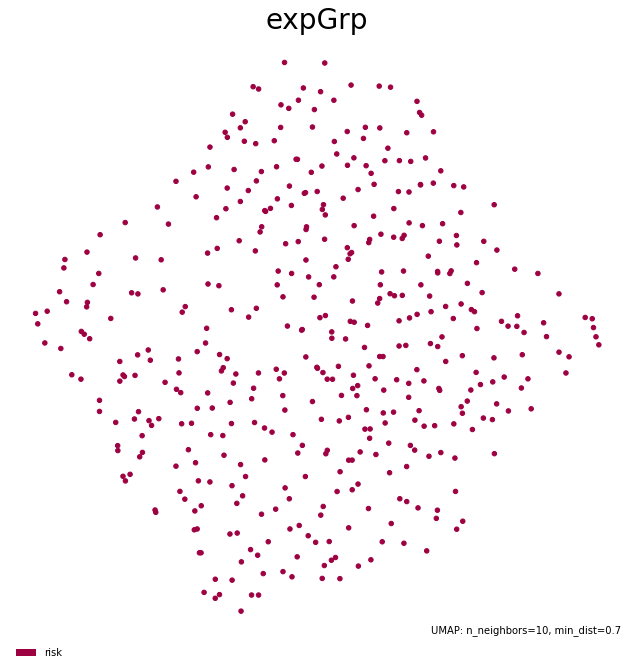

In [25]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['expGrp'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('expGrp')
plt.savefig(path_umapPlots + 'featExplore_00expGrp',bbox_inches = "tight")

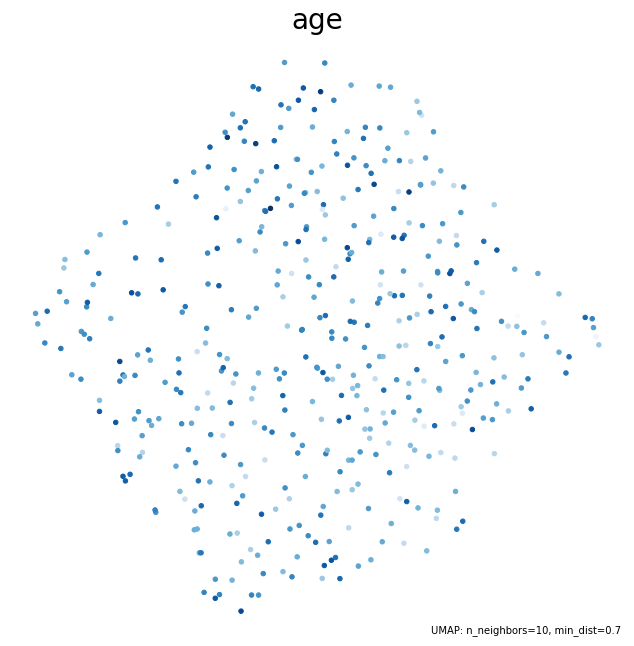

In [26]:
ax = cs_umap_plot.points(mapper, values=allFeatures['age'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('age')
plt.savefig(path_umapPlots + 'featExplore_0age',bbox_inches = "tight")

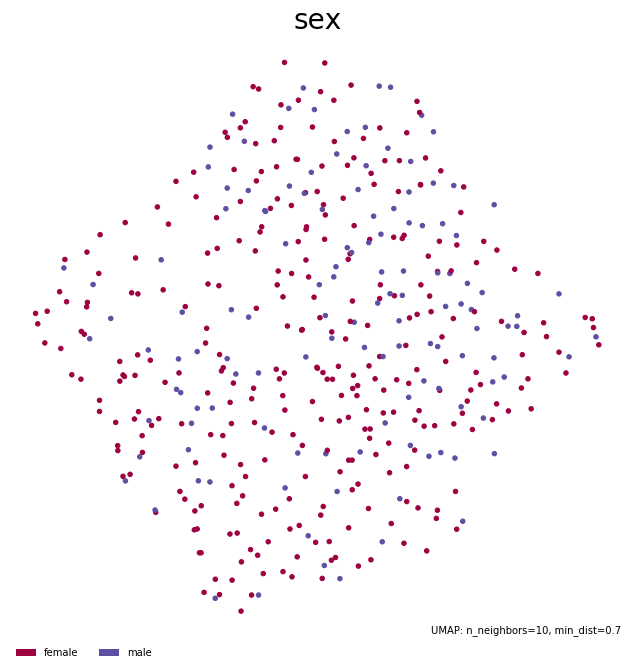

In [27]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['sex'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('sex')
plt.savefig(path_umapPlots + 'featExplore_00expGrp',bbox_inches = "tight")

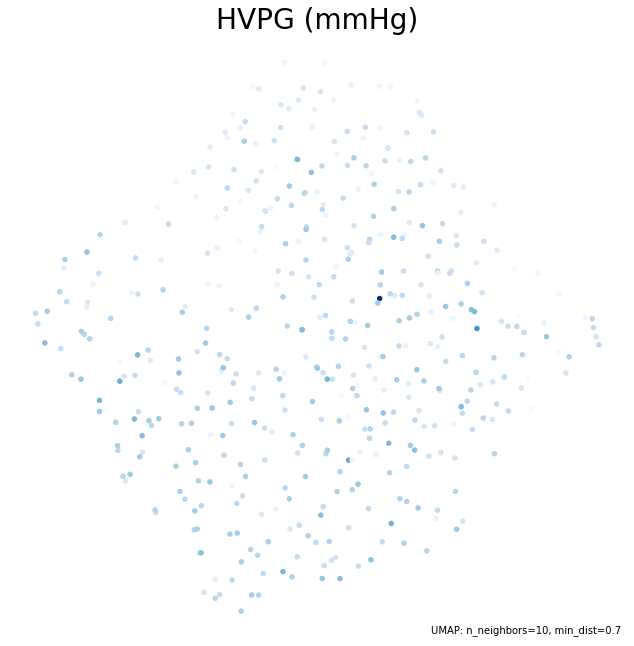

In [28]:
ax = cs_umap_plot.points(mapper, values=allFeatures['HVPG'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('HVPG (mmHg)')
plt.savefig(path_umapPlots + 'featExplore_2HVPGmmHg',bbox_inches = "tight")

In [29]:
# ax = cs_umap_plot.points(mapper, labels=allFeatures['HVPG group'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('HVPG group')
# plt.savefig(path_umapPlots + 'featExplore_2HVPGgrp',bbox_inches = "tight")

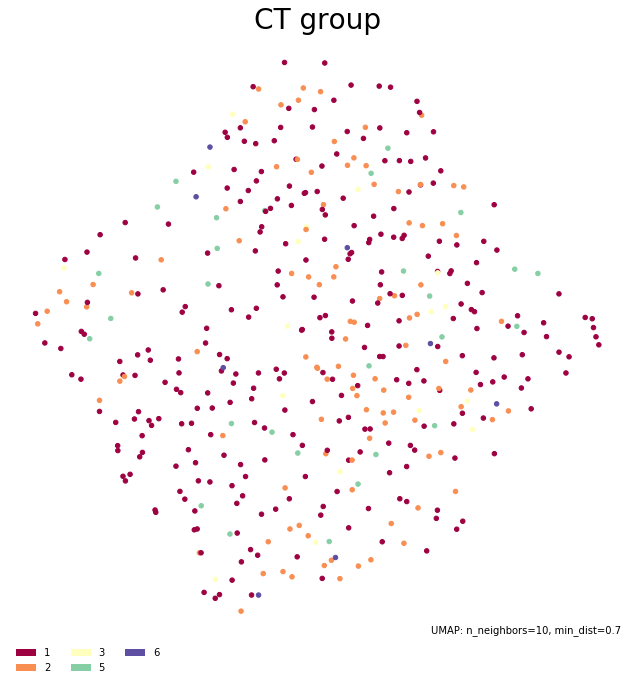

In [30]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['CTgroup'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('CT group')
plt.savefig(path_umapPlots + 'featExplore_3CTgroup',bbox_inches = "tight")

In [31]:
# ax = cs_umap_plot.points(mapper, labels=allFeatures['Etiol group'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('Etiol group')
# plt.savefig(path_umapPlots + 'featExplore_4EthiolGrp',bbox_inches = "tight")

In [32]:
# ax = cs_umap_plot.points(mapper, labels=allFeatures['OLTX status'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('OLTX status')
# plt.savefig(path_umapPlots + 'featExplore_5OLTX',bbox_inches = "tight")

In [33]:
# ax = cs_umap_plot.points(mapper, values=allFeatures['days without OLTX'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('days without OLTX')
# plt.savefig(path_umapPlots + 'featExplore_5OLTXdays',bbox_inches = "tight")

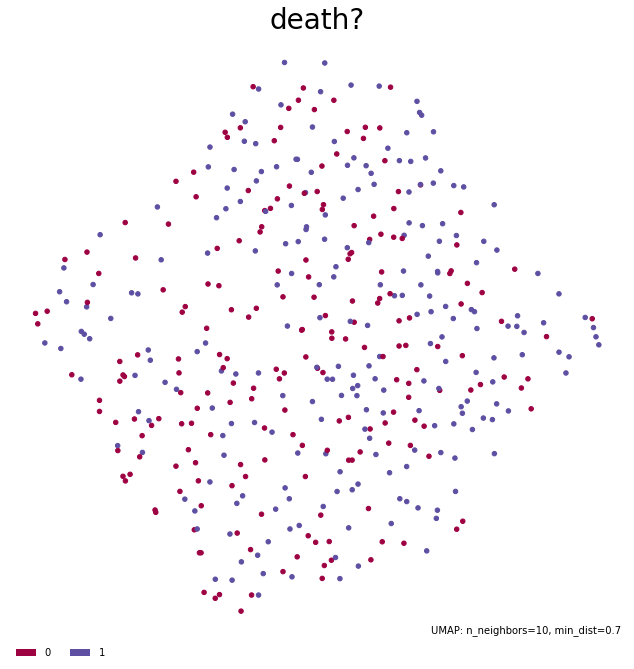

In [34]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['overallSurvival'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('death?')
plt.savefig(path_umapPlots + 'featExplore_6death',bbox_inches = "tight")

In [35]:
# ax = cs_umap_plot.points(mapper, labels=allFeatures['liver related death?'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('liver related death?')
# plt.savefig(path_umapPlots + 'featExplore_6liverDeath',bbox_inches = "tight")

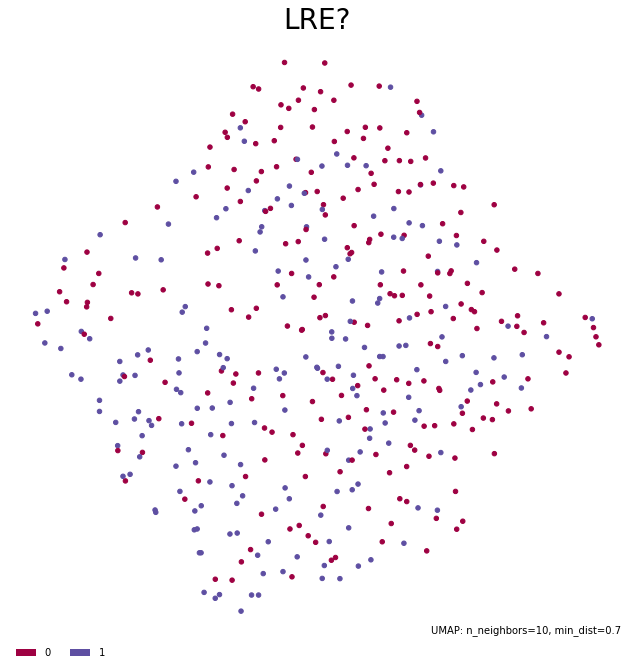

In [36]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['LRE'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('LRE?')
plt.savefig(path_umapPlots + 'featExplore_7LRE',bbox_inches = "tight")

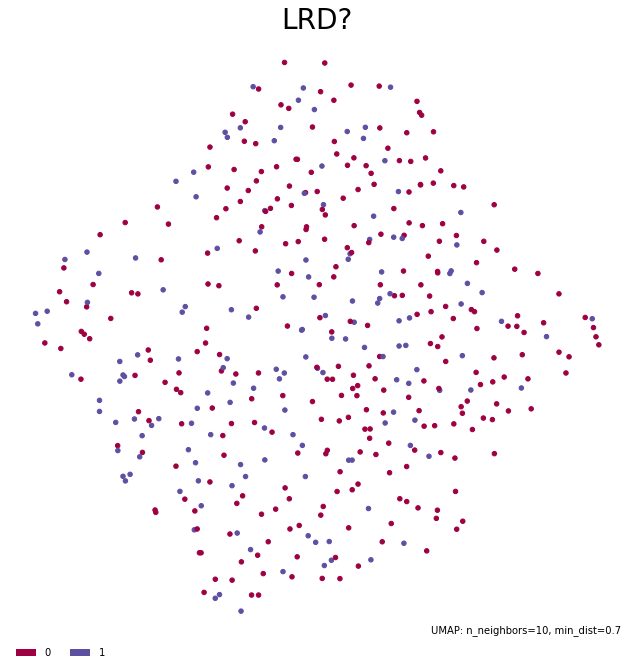

In [37]:
ax = cs_umap_plot.points(mapper, labels=allFeatures['LRD'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('LRD?')
plt.savefig(path_umapPlots + 'featExplore_7LRD',bbox_inches = "tight")

In [38]:
# ax = cs_umap_plot.points(mapper, values=allFeatures['TIPS free survival (days)'], point_size=20, show_legend=True)
# ax.axis('off')
# plt.title('TIPS free survival (days)')
# plt.savefig(path_umapPlots + 'featExplore_7TIPSdays',bbox_inches = "tight")

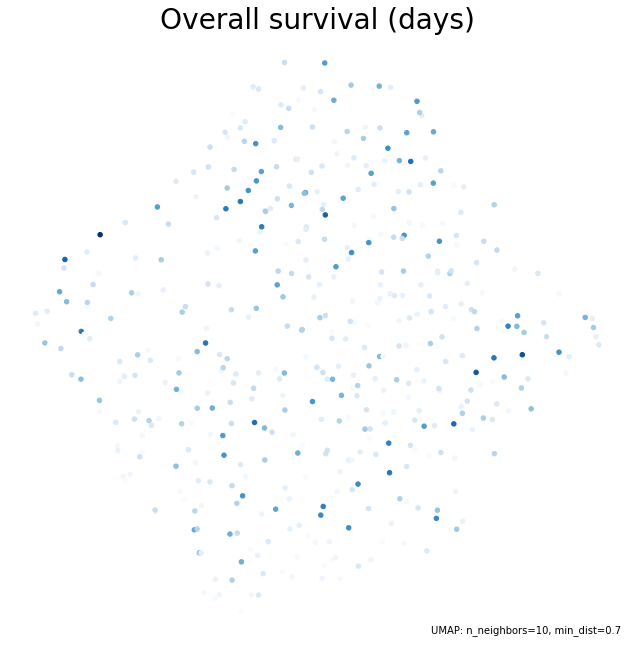

In [39]:
ax = cs_umap_plot.points(mapper, values=allFeatures['survivalDuration'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('Overall survival (days)')
plt.savefig(path_umapPlots + 'featExplore_8survival',bbox_inches = "tight")

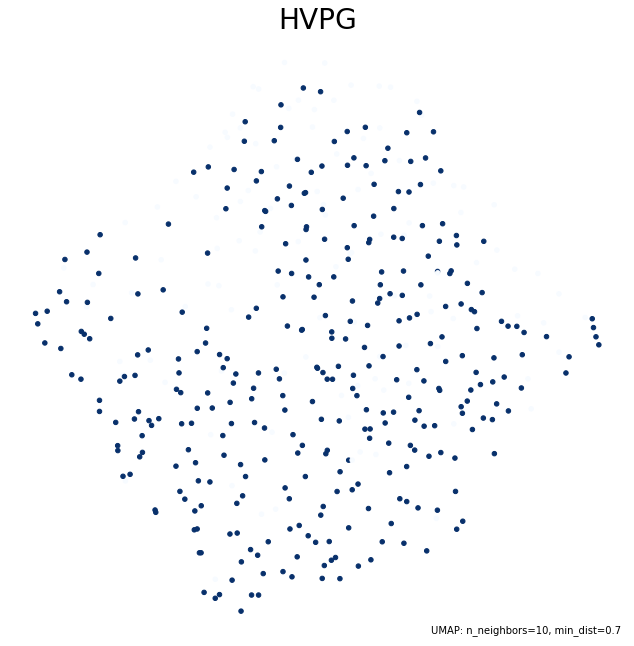

In [40]:
ax = cs_umap_plot.points(mapper, values=allFeatures['HVPG_toPredict'], point_size=20, show_legend=True)
ax.axis('off')
plt.title('HVPG')
plt.savefig(path_umapPlots + 'featExplore_9HVPG_binary',bbox_inches = "tight")

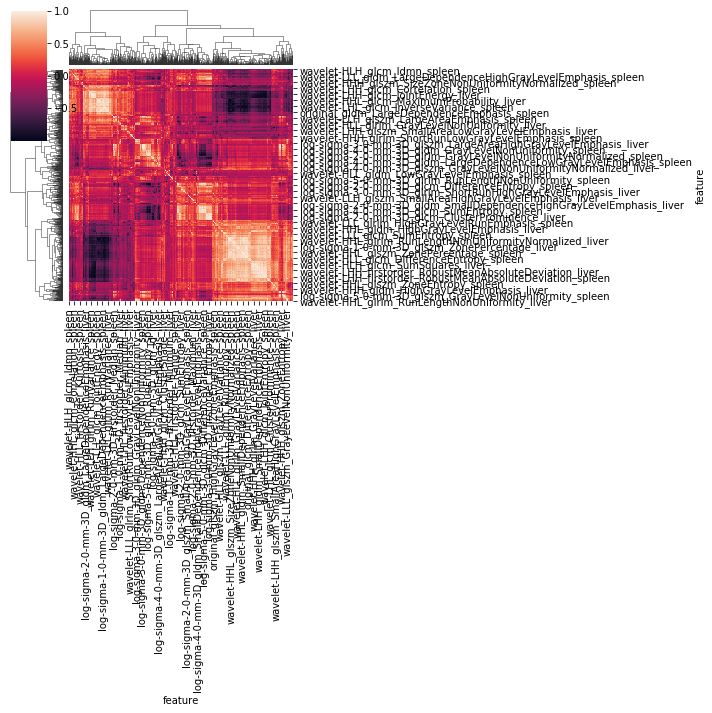

In [41]:
## filter out useless features

# retrieve clusters using fcluster 
df_featcorr = currFeatures_normctgrp.astype(float).corr(method='pearson')
d = hierarchy.distance.pdist(df_featcorr)
L = hierarchy.linkage(d, method='complete')
# 0.2 can be modified to retrieve more stringent or relaxed clusters
clusters = hierarchy.fcluster(L, 0.25*d.max(), 'distance')

# store clusters in dictionary
featCluster_dict = defaultdict(list)
for i,cluster in enumerate(clusters):
    featCluster_dict[cluster].append(df_featcorr.index[i])

currPlt = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L)
#currPlt.cax.set_visible(False)

In [42]:
print('total # of features:')
print(len(clusters))
print('# features used for model training:')
print(len(featCluster_dict))

total # of features:
2436
# features used for model training:
55


In [43]:
# random forest classifier to choose best features: we want to predict HVPG < or > 10mm

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
train_features = currFeatures_normctgrp
train_labels = np.array(currMeta['HVPG_toPredict'])
rf.fit(train_features, train_labels);

# to pair down to "important features", for each cluster, keep only feature that has the highest importance in the rf classifier
importances = list(rf.feature_importances_)
feat2keep = []

for eaCluster in featCluster_dict:
    currFeature_i = [currFeatures_normctgrp.columns.get_loc(c) for c in featCluster_dict[eaCluster]]
    currImportances = [importances[c] for c in currFeature_i]
    toKeep_i = currFeature_i[currImportances.index(max(currImportances))]
    feat2keep.append(currFeatures_normctgrp.columns[toKeep_i])

(array([118., 100., 105.,  94.,  92.,  99., 100.,  85.,  67.,  85.,  74.,
         50.,  68.,  39.,  43.,  32.,  27.,  23.,  20.,  16.,  13.,  20.,
         12.,   9.,  11.,  11.,   7.,   6.,   9.,   1.,   4.,   4.,   7.,
          2.,   2.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.]),
 array([0.0001    , 0.00011365, 0.00012916, 0.00014678, 0.00016682,
        0.00018958, 0.00021546, 0.00024486, 0.00027828, 0.00031625,
        0.00035941, 0.00040847, 0.00046421, 0.00052756, 0.00059956,
        0.00068139, 0.00077438, 0.00088006, 0.00100017, 0.00113666,
        0.00129179, 0.00146809, 0.00166844, 0.00189614, 0.00215492,
        0.00244901, 0.00278323, 0.00316307, 0.00359475, 0.00408534,
        0.00464288, 0.00527652, 0.00599663, 0.00681501, 0.00774508,
        0.00880209, 0.01000335, 0.01136855, 0.01292006, 0.01468331,
        0.01668721, 0.01896458, 0.02155276, 0.02449415, 0.02783698,
        0.03163601, 0.0359535 , 0.04086023, 0.046436

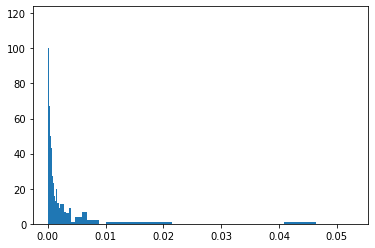

In [44]:
plt.hist(importances, bins = 10 ** np.linspace(np.log10(0.0001), np.log10(max(importances))))

In [45]:
# find the most influential features
num2list = 20

top_idx = np.argsort(importances)[-20:]
top_values = [importances[i] for i in top_idx]

currFeatures_normctgrp.columns[top_idx]

Index(['log-sigma-4-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis_liver',
       'wavelet-HHL_gldm_DependenceNonUniformity_spleen',
       'wavelet-LHL_firstorder_Median_liver', 'wavelet-HLH_glcm_Imc2_spleen',
       'log-sigma-4-0-mm-3D_glcm_SumEntropy_spleen',
       'wavelet-HLL_glcm_Correlation_spleen',
       'log-sigma-5-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis_liver',
       'log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_spleen',
       'log-sigma-3-0-mm-3D_firstorder_Median_liver',
       'log-sigma-3-0-mm-3D_gldm_GrayLevelNonUniformity_spleen',
       'log-sigma-5-0-mm-3D_gldm_GrayLevelNonUniformity_spleen',
       'wavelet-LHH_gldm_DependenceNonUniformity_spleen',
       'log-sigma-3-0-mm-3D_glcm_Imc2_spleen',
       'log-sigma-4-0-mm-3D_firstorder_Mean_spleen',
       'wavelet-HLH_firstorder_Median_liver',
       'log-sigma-5-0-mm-3D_firstorder_Mean_spleen',
       'log-sigma-4-0-mm-3D_gldm_GrayLevelNonUniformity_spleen',
       'log-sigma-3-0-mm-3D_gl

In [46]:
print('\n'.join(['{:.4f}'.format(k) for k in top_values]))

0.0057
0.0062
0.0063
0.0064
0.0064
0.0065
0.0066
0.0066
0.0075
0.0077
0.0079
0.0083
0.0108
0.0123
0.0137
0.0165
0.0173
0.0194
0.0453
0.0528


In [47]:
df_featcorr_2keep = df_featcorr[feat2keep]
df_featcorr_2keep = df_featcorr_2keep[df_featcorr_2keep.index.isin(feat2keep)]

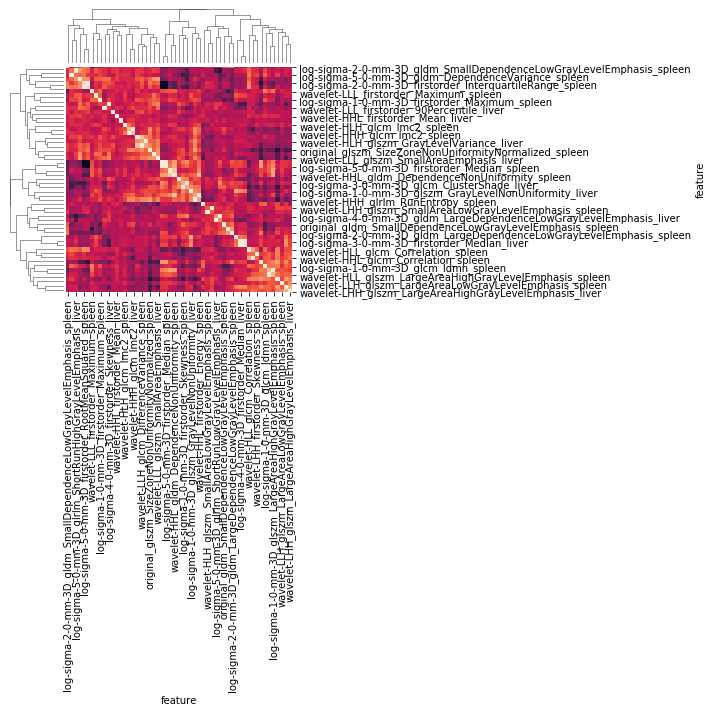

In [48]:
currPlt = sns.clustermap(df_featcorr_2keep)
currPlt.cax.set_visible(False)

In [49]:
currFeatures_normctgrp_2keep = currFeatures_normctgrp[feat2keep]

LR: 0.773016 (0.062137)
LDA: 0.793175 (0.047716)
KNN: 0.764762 (0.029421)
DTC: 0.727540 (0.060414)
GNB: 0.753175 (0.063931)
SVM: 0.807381 (0.043338)
RF: 0.827222 (0.055874)


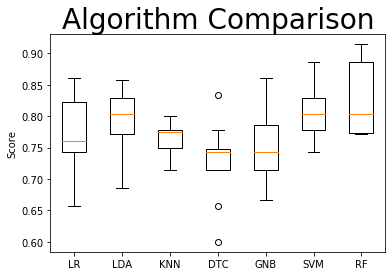

In [50]:
# 
features = currFeatures_normctgrp_2keep
labels = currMeta['HVPG_toPredict']

X_train, X_validation, Y_train, Y_validation = train_test_split(features, labels, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.ylabel('Score')
plt.title('Algorithm Comparison')
plt.show()

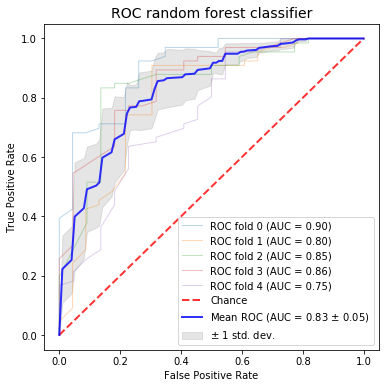

In [51]:
# #############################################################################
# Classification and ROC analysis

plt.rcParams['axes.titlesize'] = 14

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(n_estimators=100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(6,6))
for i, (train, test) in enumerate(cv.split(features, labels)):
    classifier.fit(features.values[train], labels.values[train])
    viz = plot_roc_curve(classifier, features.values[test], labels.values[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC random forest classifier")
ax.legend(loc="lower right")
plt.show()

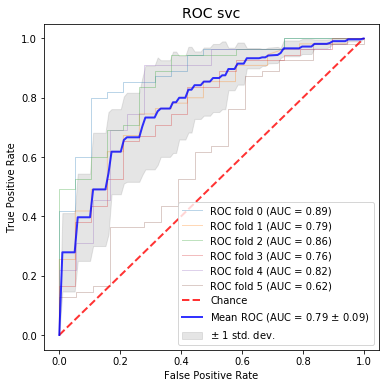

In [52]:
# #############################################################################
# Classification and ROC analysis

plt.rcParams['axes.titlesize'] = 14

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = SVC(kernel='linear', probability=True,
                 random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(6,6))
for i, (train, test) in enumerate(cv.split(features, labels)):
    classifier.fit(features.values[train], labels.values[train])
    viz = plot_roc_curve(classifier, features.values[test], labels.values[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC svc")
ax.legend(loc="lower right")
plt.show()

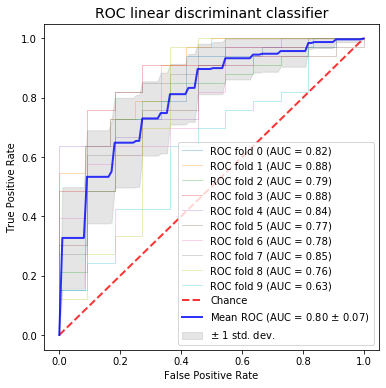

In [53]:
# #############################################################################
# Classification and ROC analysis

plt.rcParams['axes.titlesize'] = 14

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LinearDiscriminantAnalysis()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(6,6))
for i, (train, test) in enumerate(cv.split(features, labels)):
    classifier.fit(features.values[train], labels.values[train])
    viz = plot_roc_curve(classifier, features.values[test], labels.values[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC linear discriminant classifier")
ax.legend(loc="lower right")
plt.show()

In [54]:
print(datetime.datetime.now())

2023-05-10 08:05:38.956600
